In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
pip install scikit-learn

     |████████████████████████████████| 6.9MB 2.7MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


HDF5 CLASS

In [ ]:
import h5py
import os
class HDF5DatasetWriter:
	def __init__(self, dims, outputPath, dataKey="images", bufSize=1000):
		if os.path.exists(outputPath):
			raise ValueError("Output path exist cannot be overwritten. Manually delete the file before continue", outputPath)
		self.db = h5py.File(outputPath, "w")
		self.data = self.db.create_dataset(dataKey, dims, dtype="float")
		self.labels = self.db.create_dataset("labels", (dims[0],), dtype="int")
		self.bufSize = bufSize
		self.buffer = {"data":[], "labels":[]}
		self.idx = 0
	
	def add(self, rows, labels):
		self.buffer["data"].extend(rows)
		self.buffer["labels"].extend(labels)
		if (len(self.buffer["data"]) >= self.bufSize):
			self.flush()
	
	def flush(self):
		i = self.idx + len(self.buffer["data"])
		self.data[self.idx:i] = self.buffer["data"]
		self.labels[self.idx:i] = self.buffer["labels"]
		self.idx = i
		self.buffer = {"data":[], "labels":[]}
	
	def storeClassLabels(self, classLabels):
		dt = h5py.special_dtype(vlen=str)
		labelSet = self.db.create_dataset("label_names", (len(classLabels), ), dtype=dt)
		labelSet[:] = classLabels

	def close(self):
		if (len(self.buffer["data"])>0):
			self.flush()
		self.db.close()

EXTRACTING FEATURE USING VGG16 AND STORE THE EXTRACTED FEATURES AS HDF5 FILE


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelEncoder
#from pyimagesearch.io.hdf5datasetwriter import HDF5DatasetWriter
from imutils import paths
import numpy as np
import progressbar
import argparse
import random
import pandas as pd
import os

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

'''
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--dataset", help= "path to input dataset")
ap.add_argument("-o", "--output", help= "path to output HDF5 dataset")
ap.add_argument("-c", "--csv", help = "path to csv file")
ap.add_argument("-b", "--batch_size", type = int, default = 32, help= "batch size of images to be passed through network")
ap.add_argument("-s", "--buffer_size", type= int, default = 1000, help= "size of feature extraction buffer")
args = vars(ap.parse_args())
bs = args["batch_size"]
'''
bs = 32
labels = []

'''
imagePaths = list(paths.list_images(args["dataset"]))
random.shuffle(imagePaths)
labels = [p.split(os.path.sep)[-2] for p in imagePaths]
'''

'''
#After mounting the google drive
#something like /content/drive/
csvPath = "/content/drive/My Drive/Colab_Notebooks/python code/flora.csv"
datasetPath = "/content/drive/My Drive/cc78ftcdf9-1/"
outPathHDF5 = "/content/drive/My Drive/Colab_Notebooks/features.hdf5"
'''

csvPath = "/home/haroldle/pythonProject/brazilflora/flora.csv"
datasetPath = "/home/haroldle/Downloads/dataset/"
outPathHDF5 = "/home/haroldle/pythonProject/brazilflora/features.hdf5"

dataframe = pd.read_csv(csvPath)
ListImageNames = os.listdir(datasetPath)

random.shuffle(ListImageNames)

for eachImage in ListImageNames:
	findDot = eachImage.find('.')
	imageName = dataframe[dataframe["ID"] == int(eachImage[:findDot])]
	labels.append(imageName.SPECIES.values[0])
le = LabelEncoder()
labels = le.fit_transform(labels)

print("[INFO] loading network...")
model = VGG16(weights="imagenet", include_top = False)

dataset = HDF5DatasetWriter((len(ListImageNames), 512 * 7 * 7), outPathHDF5 , dataKey="features", bufSize=1000)
dataset.storeClassLabels(le.classes_)

widgets = ["Extracting Features: ", progressbar.Percentage(), " ", progressbar.Bar(), " ", progressbar.ETA()]
pbar = progressbar.ProgressBar(maxval = len(ListImageNames), widgets = widgets).start()
for i in np.arange(0, len(ListImageNames), bs):
	batchPaths = ListImageNames[i: i + bs]
	batchLabels = labels[i: i + bs]
	batchImages = []
	
	for (j, singleImage) in enumerate(batchPaths):
		singleImagePath = datasetPath + singleImage
		image = load_img(singleImagePath, target_size=(224, 224))
		image = img_to_array(image)
		image = np.expand_dims(image, axis=0)
	
		image = imagenet_utils.preprocess_input(image)
		batchImages.append(image)
  
	batchImages = np.vstack(batchImages)
	features = model.predict(batchImages, batch_size=bs)
	features = features.reshape((features.shape[0], 512*7*7))
	dataset.add(features, batchLabels)
	pbar.update(i)
dataset.close()
pbar.finish()

[INFO] loading network...


Extracting Features: 100% |#####################################| Time: 0:02:55


USING GRIDSEARCHCV WITH THE EXTRACTED FEATURES.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import h5py
import pickle
'''
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--db", help="PATH TO HDF5 DATASET")
ap.add_argument("-m", "--model", help="PATH TO OUTPUT MODEL")
ap.add_argument("-j", "--jobs", type=int, default=-1, help= "# of jobs to run when tuning hyperparameter")

args = vars(ap.parse_args())
db = h5py.File("/content/drive/My Drive/Colab_Notebooks/python code/features.hdf5","r")
'''
db = h5py.File("/home/haroldle/pythonProject/brazilflora/features.hdf5","r")
i = int(db["labels"].shape[0]*0.75)

print("[INFO] tuning hyperparameters...")
params = {"C": [0.1, 1.0, 10.0]}
model = GridSearchCV(LogisticRegression(solver="lbfgs", multi_class="auto", max_iter=10000), params, cv=3, n_jobs=-1)
model.fit(db["features"][:i], db["labels"][:i])
print("[INFO] best hyperparameter: {}".format(model.best_params_))

print("[INFO] evaluating...")
preds = model.predict(db["features"][i:])
print(classification_report(db["labels"][i:], preds, target_names=db["label_names"]))
'''
print("[INFO] saving model...")
f = open(args["model"], "wb")
f.write(pickle.dumps(model.best_estimator_))
f.close()
'''
db.close()

FEATURE EXTRACTION USING VGG16 WITH SMALLER INPUT 128X128

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelEncoder
#from pyimagesearch.io.hdf5datasetwriter import HDF5DatasetWriter
from imutils import paths
import numpy as np
import progressbar
import argparse
import random
import pandas as pd
import os
'''
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--dataset", help= "path to input dataset")
ap.add_argument("-o", "--output", help= "path to output HDF5 dataset")
ap.add_argument("-c", "--csv", help = "path to csv file")
ap.add_argument("-b", "--batch_size", type = int, default = 32, help= "batch size of images to be passed through network")
ap.add_argument("-s", "--buffer_size", type= int, default = 1000, help= "size of feature extraction buffer")
args = vars(ap.parse_args())
bs = args["batch_size"]
'''
bs = 32
labels = []

'''
imagePaths = list(paths.list_images(args["dataset"]))
random.shuffle(imagePaths)
labels = [p.split(os.path.sep)[-2] for p in imagePaths]
'''
#After mounting the google drive
#something like /content/drive/
csvPath = "/content/drive/My Drive/Colab_Notebooks/python code/flora.csv"
datasetPath = "/content/drive/My Drive/cc78ftcdf9-1/"
outPathHDF5 = "/content/drive/My Drive/Colab_Notebooks/features_128x128res.hdf5"

dataframe = pd.read_csv(csvPath)
ListImageNames = os.listdir(datasetPath)

random.shuffle(ListImageNames)

for eachImage in ListImageNames:
	findDot = eachImage.find('.')
	imageName = dataframe[dataframe["ID"] == int(eachImage[:findDot])]
	labels.append(imageName.SPECIES.values[0])
le = LabelEncoder()
labels = le.fit_transform(labels)

print("[INFO] loading network...")
model = VGG16(weights="imagenet", include_top = False, input_tensor=Input(shape=(128,128,3)))

dataset = HDF5DatasetWriter((len(ListImageNames), 512 * 4 * 4), outPathHDF5 , dataKey="features", bufSize=1000)
dataset.storeClassLabels(le.classes_)

widgets = ["Extracting Features: ", progressbar.Percentage(), " ", progressbar.Bar(), " ", progressbar.ETA()]
pbar = progressbar.ProgressBar(maxval = len(ListImageNames), widgets = widgets).start()
for i in np.arange(0, len(ListImageNames), bs):
	batchPaths = ListImageNames[i: i + bs]
	batchLabels = labels[i: i + bs]
	batchImages = []
	
	for (j, singleImage) in enumerate(batchPaths):
		singleImagePath = datasetPath + singleImage
		image = load_img(singleImagePath, target_size=(128, 128))
		image = img_to_array(image)
		image = np.expand_dims(image, axis=0)
		image = imagenet_utils.preprocess_input(image)
		batchImages.append(image)
  
	batchImages = np.vstack(batchImages)
	features = model.predict(batchImages, batch_size=bs)
	features = features.reshape((features.shape[0], 512*4*4))
	dataset.add(features, batchLabels)
	pbar.update(i)
dataset.close()
pbar.finish()

FileNotFoundError: [Errno 2] File b'/content/drive/My Drive/Colab_Notebooks/python code/flora.csv' does not exist: b'/content/drive/My Drive/Colab_Notebooks/python code/flora.csv'

CREATE A SIMPLE PROGRAM TO TEST THE TRAINING MODEL.

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.layers import Input
from google.colab.patches import cv2_imshow
import numpy as np
import h5py
import argparse
import pickle
import cv2
'''
ap =argparse.ArgumentParser()
ap.add_argument("-d", "--db", help="PATH TO THE HDF5 DATASET")
ap.add_argument("-m", "--model", help="PATH TO THE TRAIN MODEL")
ap.add_argument("-i", "--image", help="PATH TO THE IMAGE")
args = vars(ap.parse_args())
'''
testImagePath = "/content/drive/My Drive/Colab_Notebooks/dataset/cc78ftcdf9-1/1-Acrocarpus fraxinifolius/0101.jpg"
#GET THE DATA SET LABELS
db = h5py.File("/content/drive/My Drive/Colab_Notebooks/python code/features_low_res.hdf5","r")

#LOAD THE TRAIN MODEL.
model = "/content/drive/My Drive/Colab_Notebooks/python code/floras_low_res.pickle"
loaded_model = pickle.load(open(model,"rb"))

#LOAD A VGG16 MODEL WITH INPUT OF 224X224
model = VGG16(weights="imagenet", include_top = False, input_tensor=Input(shape=(128,128,3)))

#AUGMENTING THE IMAGE - BLURRING THE IMAGE USING GAUSSIANBLUR 5X5 FILTER
image = cv2.imread(testImagePath)
image = cv2.resize(image, (128,128),interpolation = cv2.INTER_AREA)
image = cv2.GaussianBlur(image, (5,5), 0)
cv2_imshow(image)

#PREPROCESS THE IMAGE
image = np.expand_dims(image, axis = 0)
image = imagenet_utils.preprocess_input(image)

#EXTRACTING FEATURE OF THE PREPROCESS IMAGE 
features = model.predict(image, batch_size = 1)
features = features.reshape((features.shape[0], 512*4*4))

preds = loaded_model.predict(features)
print(db["label_names"][preds])

PLOTTING CONFUSION MATRIX


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.22 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


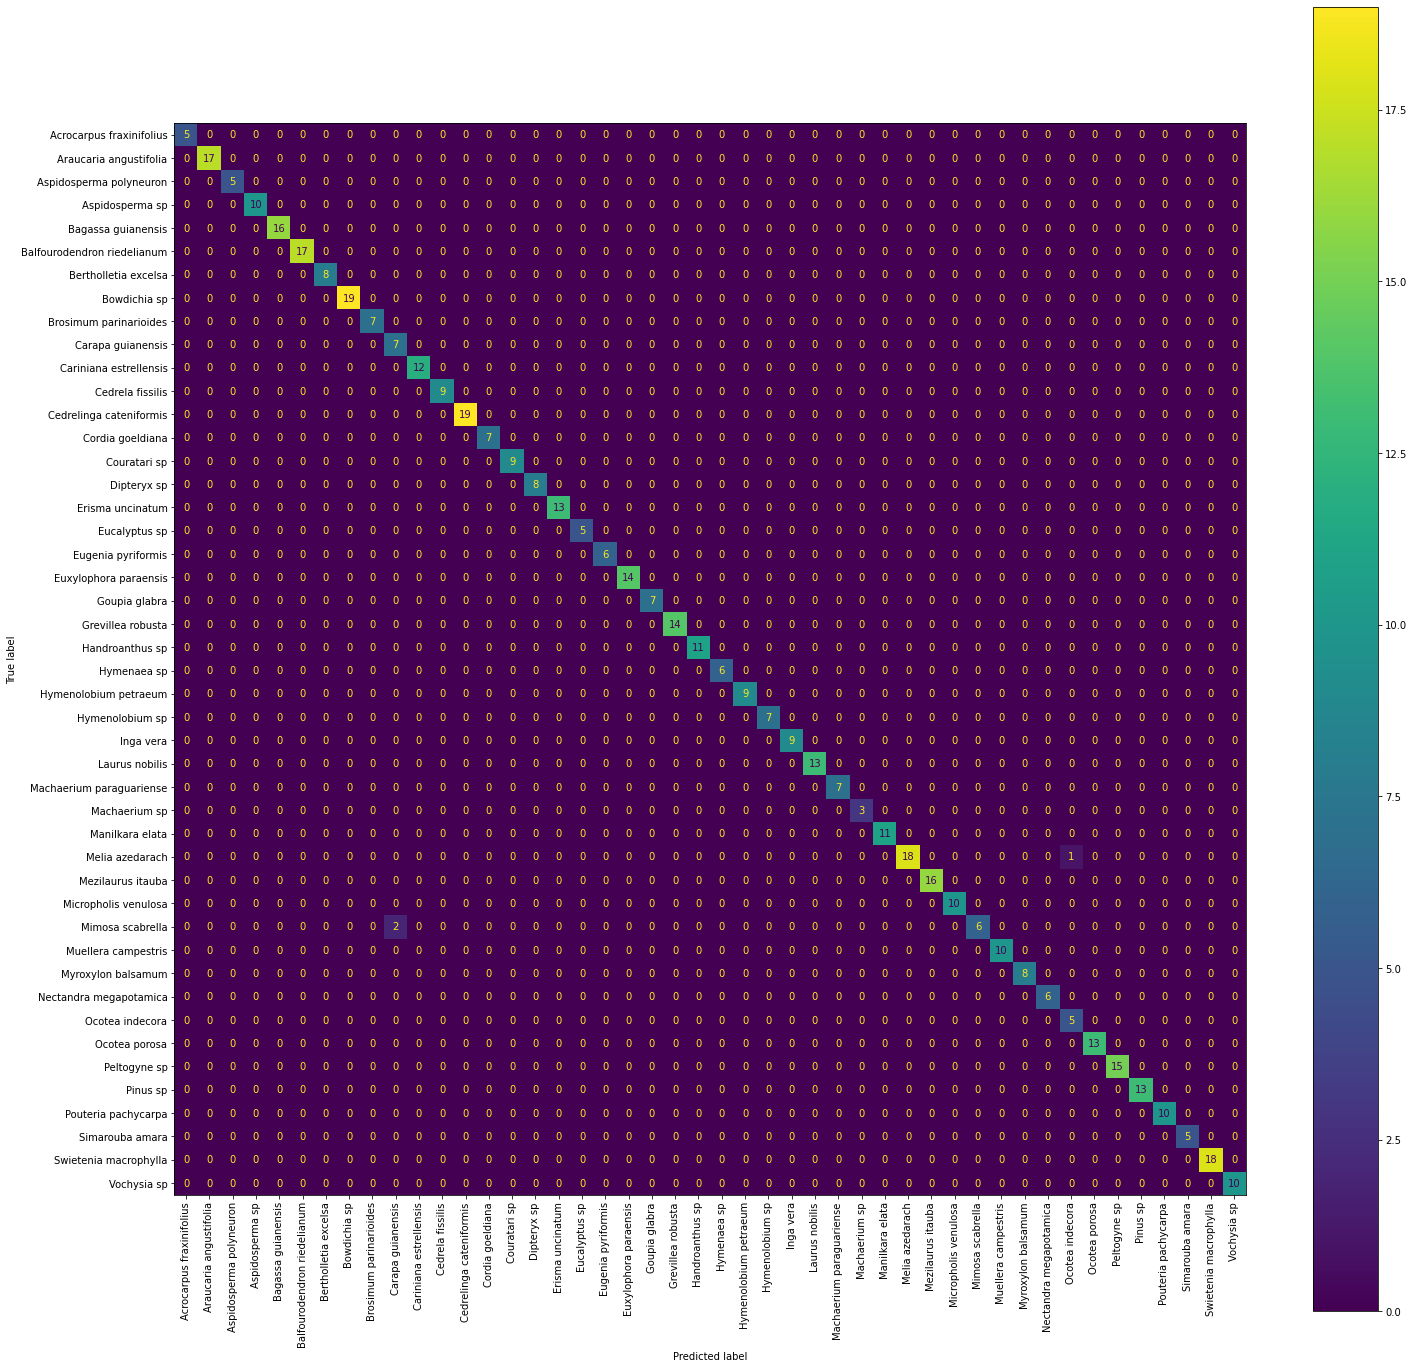

In [ ]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import h5py
import pickle

#LOAD THE TRAIN MODEL.
model = "/content/drive/My Drive/Colab_Notebooks/python code/floras.pickle"
loaded_model = pickle.load(open(model,"rb"))

#GET THE DATA SET LABELS
db = h5py.File("/content/drive/My Drive/Colab_Notebooks/python code/features.hdf5","r")
i = int(db["labels"].shape[0]*0.75)

#PLOTTING THE PREDICTING DATA SET TO THE CONFUSION MATRIX
fig, ax = plt.subplots(figsize=(24, 24))
plot_confusion_matrix(loaded_model, db["features"][i:], db["labels"][i:], display_labels=db["label_names"], ax= ax, xticks_rotation=90)
plt.grid(False)
plt.show()



PLOTTING TRAINING OR TESTING DATASET DISTRIBUTION IN BAR GRAPH

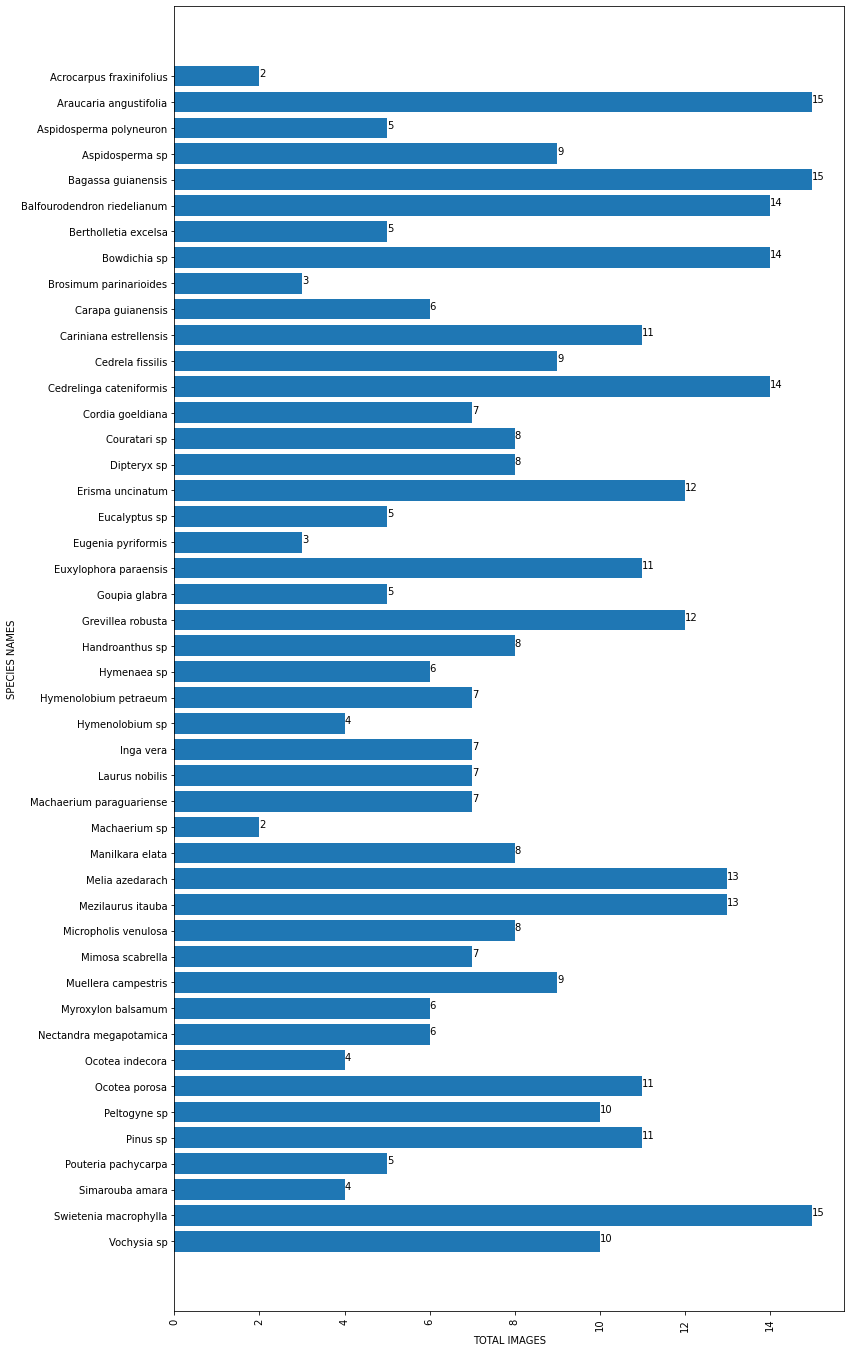

In [ ]:
import h5py
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 24))

label = {}

db = h5py.File("/content/drive/My Drive/Colab_Notebooks/python code/features.hdf5","r")
i = int(db["labels"].shape[0]*0.8)
#WARNING Either 1 for loop can be uncommented
#UNCOMMENTING For loop below for plotting the training data distribution
#for j in range(i):
#UNCOMMENTING For loop below for plotting the test data distribution
for j in range(i, db["labels"].shape[0]):
  if (not (db["label_names"][db["labels"][j]] in label.keys())):
    label[db["label_names"][db["labels"][j]]] = 1
  else:
    label[db["label_names"][db["labels"][j]]] += 1

labels, values = zip(*sorted(label.items(), reverse=True))
plt.barh(labels, values)
#ax.bar(labels, values)
plt.xticks(rotation=90)
plt.xlabel("TOTAL IMAGES")
plt.ylabel("SPECIES NAMES")
for i in range(46):
  plt.text(values[i],i,str(values[i]))
plt.show()


USING LOGISTIC REGRESSION WITH CROSS VALIDATION AND SAGA SOLVER VGG16 224x224 (TAKES TOO MUCH TIME) (STILL IN TRAINING)

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
import h5py
import pickle
'''
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--db", help="PATH TO HDF5 DATASET")
ap.add_argument("-m", "--model", help="PATH TO OUTPUT MODEL")
ap.add_argument("-j", "--jobs", type=int, default=-1, help= "# of jobs to run when tuning hyperparameter")

args = vars(ap.parse_args())
'''
db = h5py.File("/home/haroldle/pythonProject/brazilflora/features.hdf5","r")
i = int(db["labels"].shape[0]*0.8)

print("[INFO] tuning hyperparameters...")
model = LogisticRegressionCV(solver="saga", multi_class="auto", cv=3, max_iter=10000, n_jobs=-1)
model.fit(db["features"][:i], db["labels"][:i])

print("[INFO] saving model...")
f = open("/home/haroldle/pythonProject/brazilflora/LogisticCV_model_224.pickle", "wb")
f.write(pickle.dumps(model.best_estimator_))
f.close()

db.close()

GRIDSEARCHCV + SVM + 224x224 FEATURES

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import h5py
import pickle

db = h5py.File("/home/haroldle/pythonProject/brazilflora/features.hdf5","r")
i = int(db["labels"].shape[0]*0.8)
param_grid = {'C': [1, 10, 100],  'gamma': ["auto"], 'kernel': ['rbf']}
grid = GridSearchCV(SVC(decision_function_shape='ovr'), param_grid, cv= 3, n_jobs=-1)
grid.fit(db["features"][:i], db["labels"][:i])

print("[INFO] saving model...")
f = open("/home/haroldle/pythonProject/brazilflora/SVMFeature.pickle", "wb")
f.write(pickle.dumps(grid.best_estimator_))
f.close()


[INFO] saving model...


CONFUSION MATRIX SVM 224x224 FEATURES

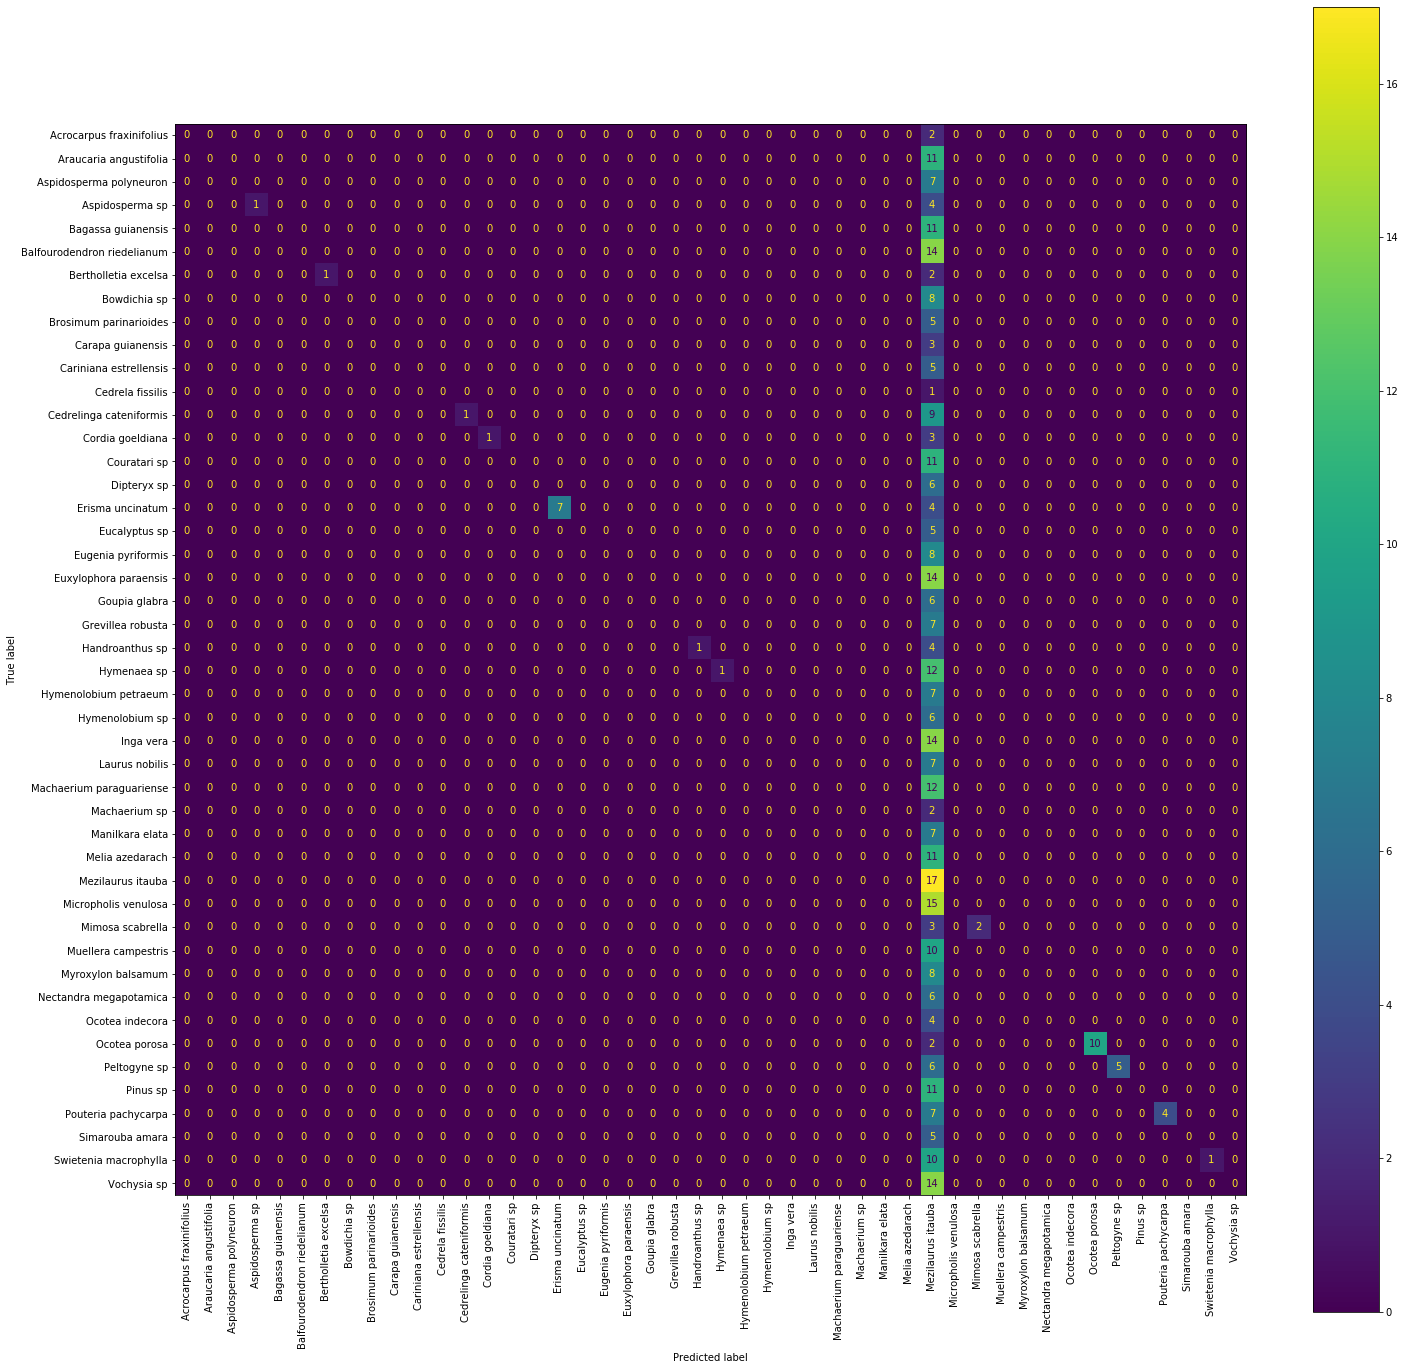

In [ ]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import h5py
import pickle

#LOAD THE TRAIN MODEL.
model = "/home/haroldle/pythonProject/brazilflora/SVMFeature.pickle"
loaded_model = pickle.load(open(model,"rb"))

#GET THE DATA SET LABELS
db = h5py.File("/home/haroldle/pythonProject/brazilflora/features.hdf5","r")
i = int(db["labels"].shape[0]*0.8)

#PLOTTING THE PREDICTING DATA SET TO THE CONFUSION MATRIX
fig, ax = plt.subplots(figsize=(24, 24))
plot_confusion_matrix(loaded_model, db["features"][i:], db["labels"][i:], display_labels=db["label_names"], ax= ax, xticks_rotation=90)
plt.grid(False)
plt.show()

RANDOM FOREST + GRIDSEARCH + 224x224 FEATURES

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import h5py
import pickle

db = h5py.File("/home/haroldle/pythonProject/brazilflora/features.hdf5","r")
i = int(db["labels"].shape[0]*0.8)
param_grid = {'n_estimators': [100, 500, 2500]}
model = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, n_jobs=-1)

model.fit(db["features"][:i], db["labels"][:i])
print("[INFO] best hyperparameter: {}".format(model.best_params_))

print("[INFO] evaluating...")
preds = model.predict(db["features"][i:])
print(classification_report(db["labels"][i:], preds, target_names=db["label_names"]))

print("[INFO] saving model...")
f = open("/home/haroldle/pythonProject/brazilflora/RandomForestCV.pickle", "wb")
f.write(pickle.dumps(model.best_estimator_))
f.close()
db.close()

[INFO] best hyperparameter: {'n_estimators': 2500}
[INFO] evaluating...
                             precision    recall  f1-score   support

   Acrocarpus fraxinifolius       1.00      1.00      1.00         2
     Araucaria angustifolia       1.00      1.00      1.00        11
    Aspidosperma polyneuron       1.00      1.00      1.00         7
            Aspidosperma sp       1.00      1.00      1.00         5
         Bagassa guianensis       1.00      1.00      1.00        11
Balfourodendron riedelianum       1.00      1.00      1.00        14
       Bertholletia excelsa       0.60      1.00      0.75         3
               Bowdichia sp       0.89      1.00      0.94         8
     Brosimum parinarioides       1.00      0.60      0.75         5
          Carapa guianensis       1.00      1.00      1.00         3
     Cariniana estrellensis       0.83      1.00      0.91         5
           Cedrela fissilis       1.00      1.00      1.00         1
    Cedrelinga cateniformis   

CONFUSION MATRIX FOR RANDOM FOREST

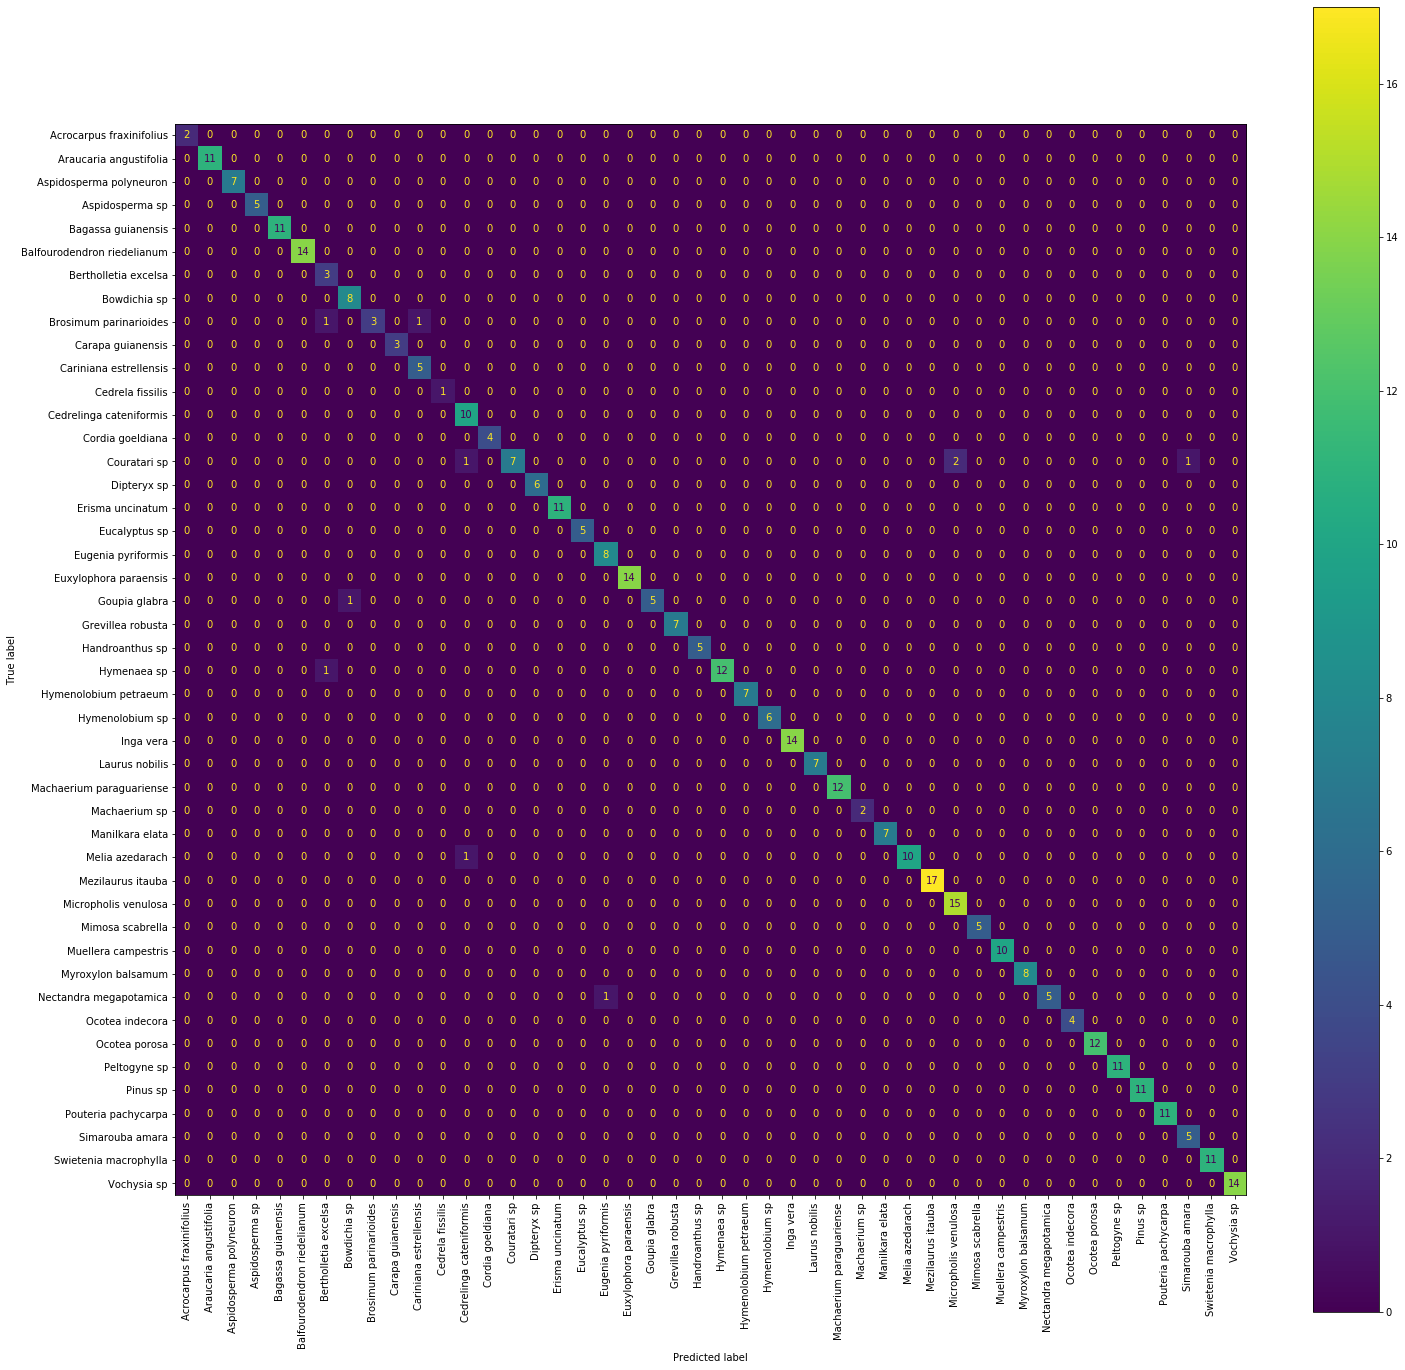

In [ ]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import h5py
import pickle

#LOAD THE TRAIN MODEL.
model = "/home/haroldle/pythonProject/brazilflora/RandomForestCV.pickle"
loaded_model = pickle.load(open(model,"rb"))

#GET THE DATA SET LABELS
db = h5py.File("/home/haroldle/pythonProject/brazilflora/features.hdf5","r")
i = int(db["labels"].shape[0]*0.8)

#PLOTTING THE PREDICTING DATA SET TO THE CONFUSION MATRIX
fig, ax = plt.subplots(figsize=(24, 24))
plot_confusion_matrix(loaded_model, db["features"][i:], db["labels"][i:], display_labels=db["label_names"], ax= ax, xticks_rotation=90)
plt.grid(False)
plt.show()